## Analysis on Pollutants Dataset

This notebook contains the analysis performed on the daily air quality dataset published by EPA. The following sections go through the data science lifecycle and raise intersting discoveries. Before we dive into detail, we first import the necessary libraries.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# import sys
# !{sys.executable} -m pip install reverse_geocoder

import numpy as np
import pandas as pd
import seaborn as sns
import reverse_geocoder as rg
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)

## Data Sampling and Collection

__Q: How were the data collected?__

The dataset on daily measured pollutants for year 2020 is collected from the Environmental Protection Agency (EPA)'s Air Data database, which contains daily emission measurements over core based statistical areas (CBSA) [1] in US. The Air Data database updates every Sunday night, so the expected lag between new data and the snapshot on database does not extend over a week [2]. The EPA also has proper method to regularly sync up with the sources (almost daily), and the EPA established May 1st as the date for which the previous year's data should be complete and accurate [2]. Given that the dataset we use is from 2018-2020, we believe there will not be syncing issues or dataset update issues.

The datasets we downloaded contain daily pollutant measurements over CBSAs in the US region for a given year. To better suit with our project, we narrowed down to the CBSAs within the California State. So, each row in the dataset represents a given station's measurement on emission (NO2, SO2, CO) in a given location at a given date. Note that the reported statistics are in terms od daily maximum.

To sum up, the dataset is collected from the Air Data database from EPA, which collects relevant emission data from measurement stations in CBSAs within the US on a daily basis.

__Q: Was there any potential bias introduced in the sampling process?__

According to [2], the air Data database's information is collected from designated measurement stations. So, there may exist selection bias, because stations that do not work with the EPA will not submit their data to the Air Data database. Also, note that the pollutant measurement for a given CBSA region is taken as the maximum among all measurement sites in that region. While this seems reasonable when we are discussing air quality (after all, we care about the extent of the badness), but in certain cases we may also want to investigate the distribution of these pollutants in that region from multiple sites. This way, it may yield new insights on that region. Maybe a sub-region in that area has a fireworks holiday, peaking the emission of that pollutant and thus causing the entire region to be "labeled" as that value. So, this "max sampling" could also induce a certain level of selection bias. However, for the purpose of our application (using several metrics to predict the air quality over a region with respect to time), I think using the max sampling is still fine, because we are not going to narrow down to each sub-region anyways.

## Data Cleaning

We inspect the dataset and perform data cleaning. Then, we discuss the findings. We start by loading the dataset, which contains three kinds of pollutants (CO, SO2, NO2) measured at all CBSA regions in California state in 2020. Note that we could also gather a similar dataset for different state using the same data cleaning process shown below.

In [2]:
CA_daily_CO = pd.read_csv("../data/CA_daily_CO_2020.csv")
CA_daily_NO2 = pd.read_csv("../data/CA_daily_NO2_2020.csv")
CA_daily_SO2 = pd.read_csv("../data/CA_daily_SO2_2020.csv")

The above three datasets follow the same format as the Air Quality Dataset. Hence, we ignore the part on inspecting these dataset. What we are interested in is how to join the tables to get the three kinds of pollutants measured at a given location with respect to time, i.e., we want the valid stations that contain all three measurements.

In [3]:
# we inner join the tables. We will deal with missing values later.
all_pollutants = pd.merge(pd.merge(CA_daily_CO, 
                                   CA_daily_NO2, 
                                   how="inner", 
                                   left_on=['Date', 'Site ID'], 
                                   right_on=['Date', 'Site ID']), 
                          CA_daily_SO2, 
                          how="inner", 
                          left_on=['Date', 'Site ID'], 
                          right_on=['Date', 'Site ID'])

all_pollutants.columns

all_pollutants_res = all_pollutants[['Date', 'Site ID', 
                                     'Daily Max 8-hour CO Concentration',
                                     'Daily Max 1-hour NO2 Concentration',
                                     'Daily Max 1-hour SO2 Concentration']]
all_pollutants_res.head()

,Date,Site ID,Daily Max 8-hour CO Concentration,Daily Max 1-hour NO2 Concentration,Daily Max 1-hour SO2 Concentration
0,01/01/2020,60010011,0.9,28.0,0.5
1,01/02/2020,60010011,1.7,34.2,1.2
2,01/07/2020,60010011,1.3,33.8,1.7
3,01/08/2020,60010011,0.8,33.4,0.8
4,01/09/2020,60010011,0.9,27.9,0.4


In [4]:
# We want to group categorize them by week and days, perhaps.
all_pollutants_res["Datetime"] = pd.to_datetime(all_pollutants_res["Date"], format="%m/%d/%Y")
all_pollutants_res["year"] = all_pollutants_res["Datetime"].dt.year
all_pollutants_res["month"] = all_pollutants_res["Datetime"].dt.month
all_pollutants_res["week"] = all_pollutants_res["Datetime"].dt.week
all_pollutants_res["day"] = all_pollutants_res["Datetime"].dt.day

all_pollutants_res = all_pollutants_res.drop(columns=["Date"])
all_pollutants_res.head()

,Site ID,Daily Max 8-hour CO Concentration,Daily Max 1-hour NO2 Concentration,Daily Max 1-hour SO2 Concentration,Datetime,year,month,week,day
0,60010011,0.9,28.0,0.5,2020-01-01,2020,1,1,1
1,60010011,1.7,34.2,1.2,2020-01-02,2020,1,1,2
2,60010011,1.3,33.8,1.7,2020-01-07,2020,1,2,7
3,60010011,0.8,33.4,0.8,2020-01-08,2020,1,2,8
4,60010011,0.9,27.9,0.4,2020-01-09,2020,1,2,9


__Q: What type of data are you exploring?__

We are exploring the weekly summaries of the numerical pollutants data in this joined dataset.

- "Datetime" encodes time-series information on when the pollutant measurement info is reported.
- "Site ID" is a qualitative nominal variable that uniquely identifies the measurement site.
- " Daily Max 8-hour CO Concentration" is a quantitatively continous variable that records the daily max 8-hour CO concentration.
- " Daily Max 1-hour NO2 Concentration" is a quantitatively continous variable that records the daily max 1-hour NO2 concentration.
- " Daily Max 1-hour SO2 Concentration" is a quantitatively continous variable that records the daily max 1-hour SO2 concentration.

We are primaily interested in the weekly summaries, as we will use these statistics to predict air quality. So we gather the weekly summaries over all stations in CA.

In [5]:
pollutants_by_week = all_pollutants_res.groupby('week').agg(np.mean)[[
    'Daily Max 8-hour CO Concentration', 
    'Daily Max 1-hour NO2 Concentration', 
    'Daily Max 1-hour SO2 Concentration'
]]

pollutants_by_week = pollutants_by_week.rename(columns={
    'Daily Max 8-hour CO Concentration': 'Weekly average Max CO',
    'Daily Max 1-hour NO2 Concentration': "Weekly average Max NO2",
    'Daily Max 1-hour SO2 Concentration': 'Weekly average Max SO2'
})

pollutants_by_week.head()

,Weekly average Max CO,Weekly average Max NO2,Weekly average Max SO2
week,,,
1,0.835714,28.432143,1.086607
2,0.713836,27.142138,1.013208
3,0.554545,25.771329,0.841259
4,0.641600,24.571200,1.012000
5,0.587097,26.591129,1.020161


__Q: What is the granularity of the data?__

In this pollutants_by_week dataframe, each row represents an summary of the air quality measurement over all stations in California that have valid measurements for all three kind of pollutants for that week.

We then check the distribution for each column over the weeks.

In [6]:
print("Max CO:")
print(pollutants_by_week["Weekly average Max CO"].describe())
print()

print("Max NO2:")
print(pollutants_by_week["Weekly average Max NO2"].describe())
print()

print("Max SO2:")
print(pollutants_by_week["Weekly average Max SO2"].describe())
print()

Max CO:
count    53.000000
mean      0.485056
std       0.210837
min       0.223649
25%       0.288387
50%       0.457534
75%       0.690062
max       0.921088
Name: Weekly average Max CO, dtype: float64

Max NO2:
count    53.000000
mean     20.392455
std       7.072984
min       9.702027
25%      14.158065
50%      19.209459
75%      26.591129
max      35.427211
Name: Weekly average Max NO2, dtype: float64

Max SO2:
count    53.000000
mean      0.889774
std       0.233320
min       0.352500
25%       0.754545
50%       0.873077
75%       1.019231
max       1.494558
Name: Weekly average Max SO2, dtype: float64



Now, based on the above analysis, we can see that there are no outliers in the dataset. For these measurements, as defined by EPA, these values are reasonable and in arange.

__Q: Are there missing value or invalid entries in the dataset?__

The original datasets (CA_daily_CO, CA_daily_NO2, CA_daily_S02) do not contain missing values, nor do they contain invalid entries. You can interactively verify this by uncommenting the next cell and changing the dataset name.

However, through the process of inner join on the three datasets, some of the stations are filtered out as they don't contain all three kinds of measurements. We make this decision because otherwise it is very hard to fill out the missing values (difficult to infer) resulted by the join.

In [7]:
#print(CA_daily_SO2.isnull().sum())

Let's inspect if we have invalid entries after the joining and aggregation. We don't.

In [8]:
print(pollutants_by_week.isnull().sum())

Weekly average Max CO     0
Weekly average Max NO2    0
Weekly average Max SO2    0
dtype: int64


We get a better sense of the distribution of data through plotting.

In [9]:
# define a plotting function to visualize distribution
def visualize_uni_distribution(df, name, ax, trans=None, prs=None):
    if trans is None:
        sns.distplot(df[name], ax=ax)
    elif trans == "log":
        if prs == "abs":
            eps = 1e-10
            sns.distplot(np.abs(np.log10(df[name] + eps)), ax=ax)

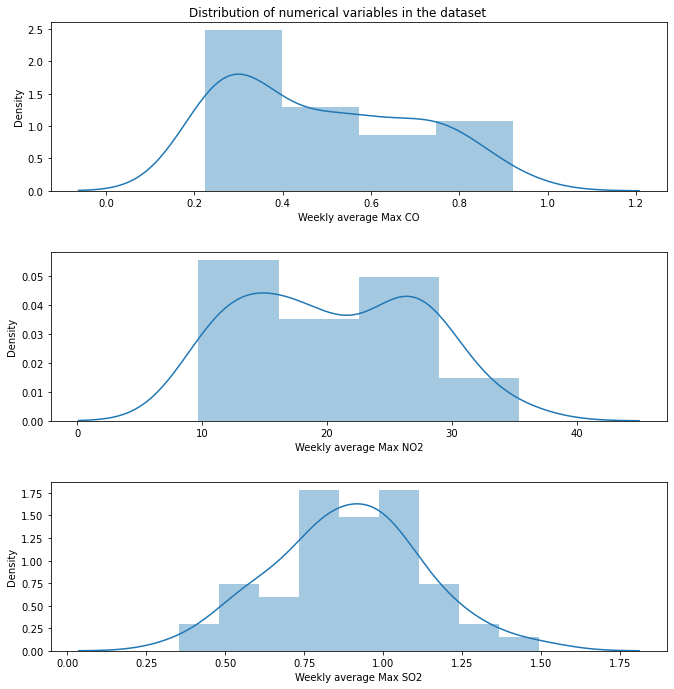

In [10]:
# we see the distribution for each variable (except SiteID, )
fig, axs = plt.subplots(3, 1, figsize=(10,10))
i = 0

for var in pollutants_by_week.columns.to_list():
    visualize_uni_distribution(pollutants_by_week, var, axs[i])
    i += 1

fig.tight_layout(pad=3.0)
fig.suptitle("Distribution of numerical variables in the dataset");

__Q: What does the distribution of the data looks like?__

__Weekly average mx CO:__
This data is unimodal. The majority of weekly average max CO values exist between 0.2-0.8 ppm. 

__Weekly average max NO2:__
This data is bimodal. The majority of weekly average max NO2 values exist between 10-35 ppb. 

__Weekly average max SO2:__
This data is unimodal and is quite symmetric. The majority of weekly average max SO2 values exist between 0.5-1.25 ppb.

## Exploratory Data Analysis

In this section, we explore the relationship between variables and getting to know more about the data. Note that, in the end, we will integrate these pollutants data with the rest of the datasets (temperature, precipitation, wind) to predict air quality, in a time-series based model. So, we will gather another analysis notebook to explore the correlation between the features and the column to predict. For now, we are just trying to explore some basic elements of this dataset. Please be assured that more will follow in the final notebook :)

__Exploration 1: What months tend to produce higher pollutants in each category? Does the discovery align with scientific explanation? If we inspect the relationship in terms of weeks, would we find a oscillation pattern?__

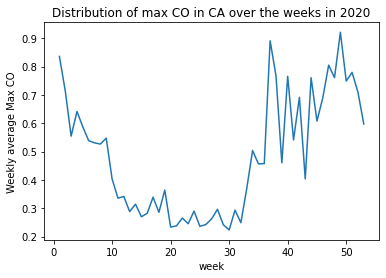

In [15]:
sns.lineplot(data=pollutants_by_week, x='week', y='Weekly average Max CO');
plt.title("Distribution of max CO in CA over the weeks in 2020");
plt.savefig("../figures/week_and_co.png");

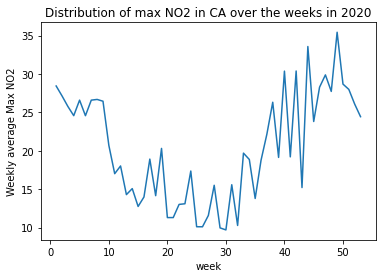

In [12]:
sns.lineplot(data=pollutants_by_week, x='week', y='Weekly average Max NO2');
plt.title("Distribution of max NO2 in CA over the weeks in 2020");

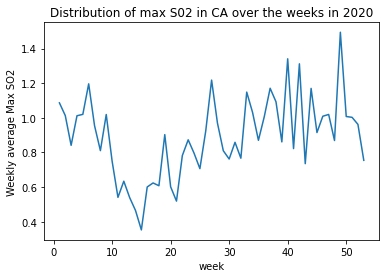

In [13]:
sns.lineplot(data=pollutants_by_week, x='week', y='Weekly average Max SO2');
plt.title("Distribution of max S02 in CA over the weeks in 2020");

From the above three plots for all three kinds of pollutants, we can see that indeed there is an oscillation going on for every month. By nature, we know many phenomons oscillate with respect to time, and this is true for pollutants as well. This oscillation can be taken into account when we build the model later on.

To answer the first question, we can see that CO and NO2 emission graphs share similar trend. This is expected due to how human activities vary with respect to months. We know that CO is mostly found in fumes produced by cars, trucks, and etc, and NO2 is mostly produced by cars, power plants. In the summer, people in California use AC to cool themselves, and that emits quantitatively more of the above pollutants as compared to other months, so we see the peak in the two graphs respectively. For SO2, it's mostly attributed to the power plants and industrial facilities, which are on all year round, mostly. So, we observed a pattern that is more stable across the year. The above plot suggests that both NO2 and CO could be useful predictors for air quality, as they share similar trend as the AQI (analyzed in a separate notebook). However, the SO2 does not seem too helpful, given that it is quite stable over the year.

__Exploration 2: Is there a correlation between daily max CO and daily max NO2? In other words, when one of the pollutants is high, do we expect the other pollutant to also be high?__

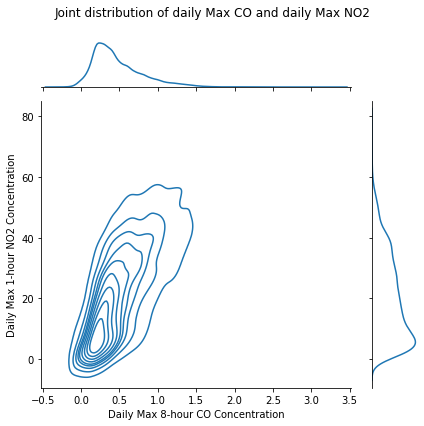

In [16]:
fig = sns.jointplot(data=all_pollutants_res, x="Daily Max 8-hour CO Concentration", 
                y="Daily Max 1-hour NO2 Concentration", kind="kde");
fig.fig.suptitle("Joint distribution of daily Max CO and daily Max NO2");
fig.fig.tight_layout()
fig.fig.subplots_adjust(top=0.9) # Reduce plot to make room 
plt.savefig("../figures/co_and_no2.png")

From the above joint kde plot, we can see that indeed there is a positive correlation (though not strong) between the max daily CO emission and max daily NO2 emission. This validates our assumption, as we know that cars, power plants produce a combination of CO and NO2. So, when we see the CO emission is high for a given day, we expect to see also high emission of NO2 in general.

__Q: Is there any correlation between the variables you are interested in exploring?__

From the above section of analysis, we can see that:

- There is a relationship between the month and the averaged max CO / NO2 emission for that month. This is due to how season transitions and the different level of human activities associated with each month.
- There is a positive correlation between daily max CO and daily max NO2. Given that cars, factories emit both kinds of pollutants, it is expected that when one pollutant has high value, the other would follow that trend.

From the above discoveries, we are more and more assured about using these data to predict air quality, because from EDA, we observed trends that align with our expectation. There will be a separate notebook to combine all these datasets togther and conduct more EDA on variables.

__Q: How would you cleanly and accurately visualize the relationship among variables?__

This question is answered as we walk through the above three explorations. Basically, several techniques are used to cleanly and accurately visualize the relationship.

To observe clean and clear trend, we use:

- plot the average over the months instead of all data
- proper selction of graphing method and use proper color, and display size

## Reference


[1] https://aqs.epa.gov/aqsweb/documents/codetables/cbsas.html

[2] https://www.epa.gov/outdoor-air-quality-data/air-data-frequent-questions

